# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

         1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

         2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

         3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn
import seaborn as sns

%matplotlib inline
import datetime

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


In [2]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)


# Put data in Dataframe
user_df = pd.DataFrame(data)

In [3]:
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
user_df['signup_date']

0        2014-01-25
1        2014-01-29
2        2014-01-06
3        2014-01-10
4        2014-01-27
            ...    
49995    2014-01-25
49996    2014-01-24
49997    2014-01-31
49998    2014-01-14
49999    2014-01-18
Name: signup_date, Length: 50000, dtype: object

In [5]:
len(user_df[user_df['trips_in_first_30_days' ]>0])

34610

In [6]:
(34610/50000)*100

69.22

In [7]:
user_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
user_df.last_trip_date = pd.to_datetime(user_df.last_trip_date)
#user_df['last_trip_date'].describe(datetime_is_numeric=True)
user_df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The last trip was taken on July 1st. So, a user will be considered retained if they were “active” (i.e. took a trip) in the preceding 30 days which is the month of June in this case ! 

In [9]:
Percent_retained = 100*(user_df.last_trip_date >= '2014-06-01').sum() / (user_df.last_trip_date >= '2014-06-01').count()
Percent_retained

37.608

So, the retention is 37.61 percentage.

In [10]:
user_df['was_retained'] = (user_df.last_trip_date >= '2014-06-01')*1
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [11]:
user_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  object        
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  was_retained            50000 non-null  int64 

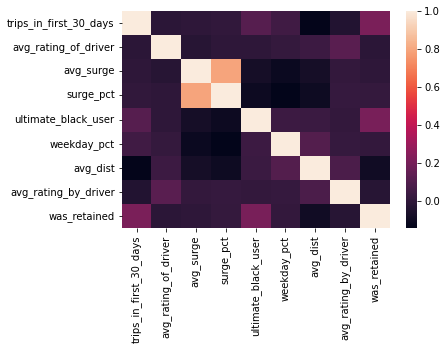

In [12]:
fig = plt.figure()
sns.heatmap(user_df.corr())
plt.show()

In [13]:
corr = user_df.corr()
corr['was_retained'].sort_values(ascending=False)

was_retained              1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: was_retained, dtype: float64

So, we see that whether a user was retained or not is somewhat correlated with the 
number of trips in the first 30 days and whether they are an Ultimate Black 
user or not. There isn't much correlation or anti-correlation with other features.

In [14]:
# Check non-numeric features -- begin with city.
user_df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

Only Three cities.

In [15]:
# And phone.
user_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Only two phones.

Both columns have string values. We seek to one-hot-encode the 2 columns. The dimensionality will not 
increase substantially as both columns have so few values.

In [16]:
1*user_df.phone.isna().sum()

396

In [17]:
user_df.phone.fillna('Other', inplace=True)
user_df.phone.value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

So, nulls replaced with Other here.

In [18]:
1*user_df.city.isna().sum()

0

In [19]:
pd.get_dummies(user_df['city']).head()

,Astapor,King's Landing,Winterfell
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,1


In [20]:
city_ohe = pd.get_dummies(user_df['city'])
phone_ohe = pd.get_dummies(user_df['phone'])

In [21]:
user_df = user_df.join(city_ohe).join(phone_ohe)

In [22]:
user_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [23]:
user_df.drop(['city', 'phone'], axis=1, inplace=True)

In [24]:
user_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [25]:
# Move 'was_retained' to the end of the columns
col_at_end = ['was_retained']
user_df = user_df[[c for c in user_df if c not in col_at_end] 
        + [c for c in col_at_end if c in user_df]]

In [26]:
user_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0,0


In [27]:
[c for c in user_df if c not in col_at_end]

['trips_in_first_30_days',
 'signup_date',
 'avg_rating_of_driver',
 'avg_surge',
 'last_trip_date',
 'surge_pct',
 'ultimate_black_user',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'Astapor',
 "King's Landing",
 'Winterfell',
 'Android',
 'Other',
 'iPhone']

In [28]:
[c for c in col_at_end if c in user_df]

['was_retained']

In [29]:
user_df.describe().iloc[:, -7:-1]

,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see about 33 % of users are from Astapor, about 20 % are from King's Landing, and about 47 % are from Winterfell. Meanwhile, about 70 % of users use an iPhone, while the rest (30 %) use Android. There is a very
small percentage which doesn't use either.

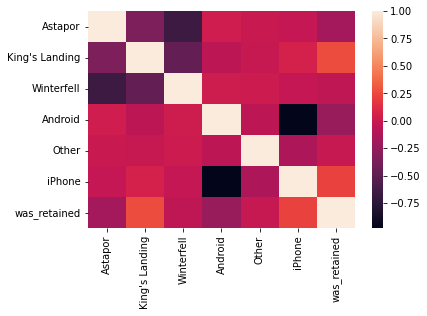

In [30]:
user_df1 = user_df.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr1 = user_df1.corr()
ax = sns.heatmap(corr1)
plt.show()

We see that being from King's Landing and using an iPhone are associated with being retained. 
Being from Astapor or Winterfell or using an Android are negatively correlated with retention.

In [31]:
corr1['was_retained'].sort_values(ascending=False)

was_retained      1.000000
King's Landing    0.262284
iPhone            0.225244
Other            -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: was_retained, dtype: float64

In [32]:
user_df.signup_date.describe()

count          50000
unique            31
top       2014-01-18
freq            2948
Name: signup_date, dtype: object

In [33]:
user_df.signup_date.describe()

count          50000
unique            31
top       2014-01-18
freq            2948
Name: signup_date, dtype: object

In [34]:
Test = []

for j in range(0,len(user_df['signup_date'])):
    Test.append(int(datetime.datetime.strptime(user_df['signup_date'][j], "%Y-%M-%d").strftime("%Y%m%d")) - 20140100)      

In [35]:
user_df['signup_date'] = Test

In [36]:
user_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
0,4,25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1,1
1,0,29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0,0
2,3,6,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1,0
3,9,10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1,1
4,14,27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0,0


In [37]:
user_df['signup_date'].corr(user_df['was_retained'])


-0.020210618434848296

The signup date doesn't seem to be correlated with retention. Let's check last_trip_date. It is expected this should be very correlated. 

In [38]:
ref = min(user_df['last_trip_date'])

user_df['last_trip_date'] = (user_df['last_trip_date'] - ref).dt.days + 1 

# We add 1 to number of days since the first day (not since last year).

In [39]:
user_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
0,4,25,4.7,1.10,168,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1,1
1,0,29,5.0,1.00,125,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0,0
2,3,6,4.3,1.00,7,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1,0
3,9,10,4.6,1.14,180,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1,1
4,14,27,4.4,1.19,74,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0,0


In [40]:
user_df['last_trip_date'].corr(user_df['was_retained'])


0.7808374961937251

Very high correlation as expected.

In [41]:
user_df['ultimate_black_user'] = user_df['ultimate_black_user']*1 # To convert boolean into integer

In [42]:
user_df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
count,50000.000000,50000.00000,41878.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,0.37708,60.926084,5.796827,4.778158,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640,0.376080
std,3.792684,8.75422,0.617338,0.222336,61.718985,19.958811,0.48466,37.081503,5.707357,0.446652,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821,0.484405
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.00000,4.300000,1.000000,45.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.00000,4.900000,1.000000,128.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have looked at the relationship between every feature and our target column 'was_retained'. The 'city' and phone' columns are one-hot-encoded and the date columns are converted to number of days into 2014. The 'ultimate_black_user' is converted to integer.

So, all the features are numeric now. That takes us to modelling.

2. Build a predictive model to help Ultimate determine whether or not a user
will be active in their 6th month on the system. Discuss why you choose your 
approach, what alternatives you considered, and any concerns you have. 
How valid is your model? Include any key indicators of model performance.

Steps Involved in Classification in Scikit-Learn:

    1.) Preprocess Data
    2.) Create Train and Test Sets
    3.) Instantiate the model/estimator (Steps 1 and 3 can be combined in a Pipeline object)
    4.) Specify Hyperparameter Space
    5.) Instantiate GridSearchCV or RandomizedSearchCV objects
    6.) Fit CV object to the Training Set
    7.) Predict on the Test Set
    8.) Compute Scores for the Model


Models:

    1.) Logistic Regression (LR)
    2.) K-Nearest Neighbor (KNN)
    3.) Support Vector Machine (SVM)
    4.) Decision Trees (DT)
    5.) Random Forest (RF)
    6.) Naive Bayes (NB)

In [43]:
# import modules and packages

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time
import datetime

We create the whole model using sklearn's Pipeline object.  We repull the data to do this.


In [44]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# Put data in Dataframe
user_df = pd.DataFrame(data)


user_df['was_retained'] = (user_df.last_trip_date >= '2014-06-01')*1
user_df.last_trip_date = pd.to_datetime(user_df.last_trip_date)
user_df.signup_date = pd.to_datetime(user_df.signup_date)

Test1 = []

for j in range(0,len(user_df['signup_date'])):
    Test1.append(int((user_df['signup_date'][j]).strftime("%Y%m%d")) - 20140100)

user_df['signup_date'] = Test1

user_df['last_trip_date'] = (user_df['last_trip_date'] - min(user_df['last_trip_date'])).dt.days + 1

In [45]:
# Step 1) Preprocess Data

np.random.seed(0)

user_df.phone.fillna('Other', inplace=True)
cat_features = ['city', 'phone'] # categorical features

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())])

num_features = [col for col in user_df.columns.tolist() if col not in cat_features and
                col not in ['last_trip_date', 'was_retained']] # numeric features

# excluding these two columns as 'last_trip_date' will bias the model but 'was_retained' is the target  

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_features), 
                  ('cat', cat_transformer, cat_features)])

In [46]:
#### Step 2) Split Data into Training and Test Sets

X = user_df.drop(['was_retained', 'last_trip_date'], axis=1)
Y = user_df['was_retained']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

In [47]:
# Create a metrics dataframe
met = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes'])

In [48]:
met

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest,Naive Bayes
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time to Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# We define a function for training and scoring our models.

def train_and_score_model(model_name, estimator, param_grid=None, cv=5, iid=False):
    
    #### Step 5: Instantiate the CV Object
    
    if model_name in ['Dummy Model', 'Naive Bayes']:
        cv = estimator
    elif model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv, iid=False)
    else: 
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, iid=False, random_state=None)

    #### Step 6: Fit on Training
    t0 = time.time()
    cv.fit(X_train, Y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    met.loc['Time to Train', model_name] = ttt

    #### Step 7: Predict on Test

    y_pred = cv.predict(X_test)

    #### Step 8: Scoring
    ##### Accuracy

    print("Accuracy with " + model_name + " on the testing set is: %.3f" % cv.score(X_test, Y_test))

    met.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=Y_test)
    met.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=Y_test)
    met.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=Y_test)
    
    if model_name != 'Support Vector Machine':
        y_pred_prob = cv.predict_proba(X_test)[:,1]
        met.loc['AUC', model_name] = roc_auc_score(Y_test, y_pred_prob)

    print(Conf_Matrix(confusion_matrix(Y_test, y_pred)))
    print(classification_report(Y_test, y_pred))

    if model_name != 'Support Vector Machine':
        # ROC Curve
        fpr, tpr, thresholds  = roc_curve(Y_test, y_pred_prob)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('%s ROC Curve' % model_name)
        plt.show()

    return cv

In [50]:
# Define Confusion Matrix

def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint

# Step 3: Instantiate the model/estimator
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_svm = SVC(random_state=0)
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)
classifier_nb = GaussianNB()

classifiers = [classifier_dm, classifier_lr, classifier_knn, classifier_svm, classifier_dt, classifier_rf, classifier_nb]

# Step 4: Specify the Hyperparameter Space
param_grid_dm = None
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20)
}
param_grid_svm = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01]
}
param_grid_dt = {
                'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'classifier__max_depth': [3, 10, 20, None],
                'classifier__max_features': randint(1, 9),
                'classifier__min_samples_leaf': randint(1, 9),
                'classifier__min_samples_split': randint(2, 9),
                'classifier__criterion': ["gini", "entropy"]
}
param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': [50, 100],
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': [3, 10, 20, None],
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}
param_grid_nb = None

param_grids = [param_grid_dm, param_grid_lr, param_grid_knn, param_grid_svm, param_grid_dt, param_grid_rf, param_grid_nb]

model_names = ['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes']
cv_names = ['dm_cv', 'lr_cv', 'knn_cv', 'svm_cv', 'dt_cv', 'rf_cv', 'nb_cv']
cvs = [None, 5, 5, 5, 5, 5, 5]

It takes 0.294 seconds for Dummy Model fitting
Accuracy with Dummy Model on the testing set is: 0.624
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          9359         0   9359
Retained              5641         0   5641
Total                15000         0  15000


/home/kc3pve/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kc3pve/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      9359
           1       0.00      0.00      0.00      5641

    accuracy                           0.62     15000
   macro avg       0.31      0.50      0.38     15000
weighted avg       0.39      0.62      0.48     15000



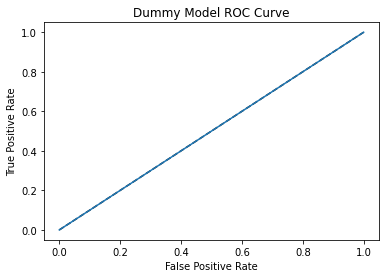

In [52]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                 ('classifier', classifier_dm)])
dm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)

It takes 108.667 seconds for Logistic Regression fitting
Accuracy with Logistic Regression on the testing set is: 0.716
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7984      1375   9359
Retained              2880      2761   5641
Total                10864      4136  15000
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9359
           1       0.67      0.49      0.56      5641

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



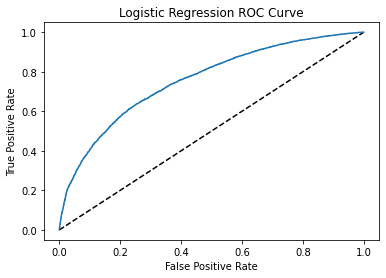

In [53]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

It takes 170.518 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighbors on the testing set is: 0.750
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7739      1620   9359
Retained              2125      3516   5641
Total                 9864      5136  15000
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      9359
           1       0.68      0.62      0.65      5641

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000



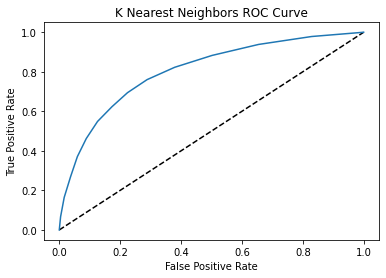

In [54]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])
knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

In [55]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_svm)])
svm_cv = train_and_score_model('Support Vector Machine', pipeline, param_grid_svm)

It takes 4880.081 seconds for Support Vector Machine fitting
Accuracy with Support Vector Machine on the testing set is: 0.767
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8178      1181   9359
Retained              2307      3334   5641
Total                10485      4515  15000
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9359
           1       0.74      0.59      0.66      5641

    accuracy                           0.77     15000
   macro avg       0.76      0.73      0.74     15000
weighted avg       0.76      0.77      0.76     15000



It takes 6.702 seconds for Decision Tree fitting
Accuracy with Decision Tree on the testing set is: 0.759
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7867      1492   9359
Retained              2117      3524   5641
Total                 9984      5016  15000
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      9359
           1       0.70      0.62      0.66      5641

    accuracy                           0.76     15000
   macro avg       0.75      0.73      0.74     15000
weighted avg       0.76      0.76      0.76     15000



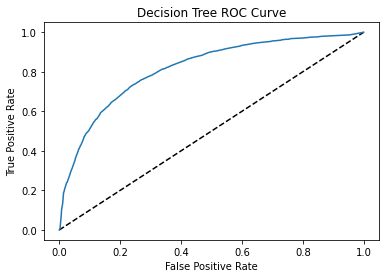

In [56]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_dt)])
dt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)


It takes 81.616 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.778
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8037      1322   9359
Retained              2002      3639   5641
Total                10039      4961  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.73      0.65      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



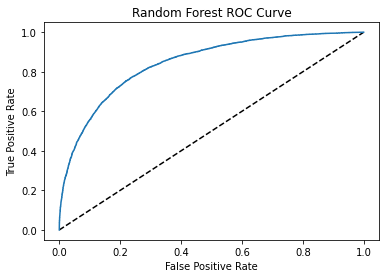

In [57]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

It takes 0.131 seconds for Naive Bayes fitting
Accuracy with Naive Bayes on the testing set is: 0.692
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          6419      2940   9359
Retained              1678      3963   5641
Total                 8097      6903  15000
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      9359
           1       0.57      0.70      0.63      5641

    accuracy                           0.69     15000
   macro avg       0.68      0.69      0.68     15000
weighted avg       0.71      0.69      0.70     15000



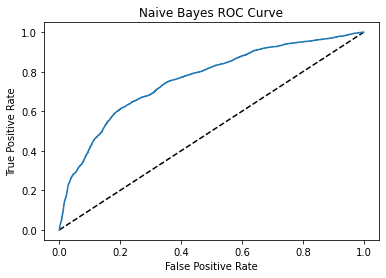

In [58]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)

In [59]:
from pandas.plotting import table
met.astype(float).round(3)
actual_met = met.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
actual_met

,Dummy Model,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Decision Tree,Random Forest,Naive Bayes
accuracy,62.4,71.6,75.0,76.7,75.9,77.8,69.2
precision,0.0,66.8,68.5,73.8,70.3,73.4,57.4
recall,0.0,48.9,62.3,59.1,62.5,64.5,70.3
AUC,50.0,75.7,80.4,NaN,81.6,84.5,76.1


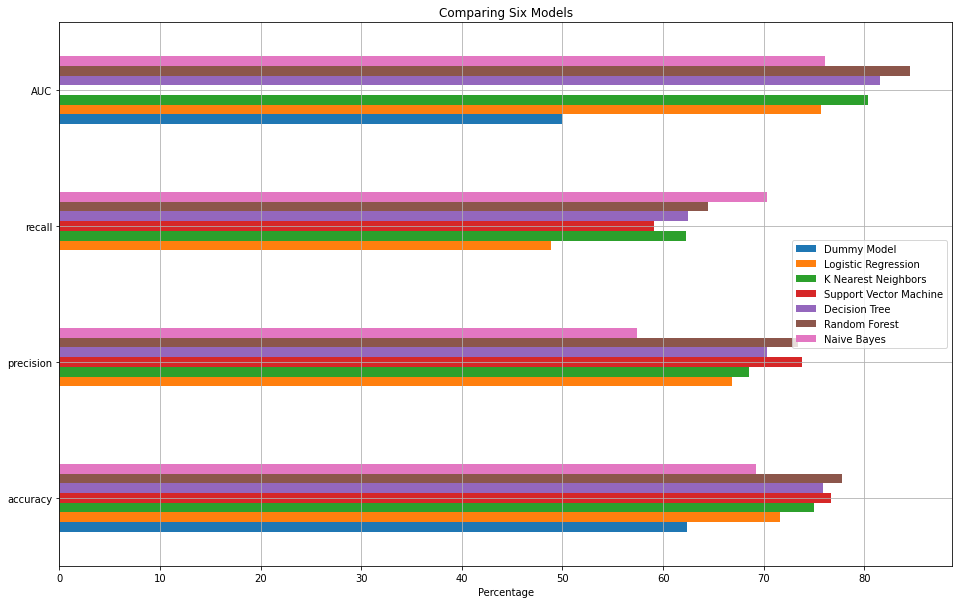

In [60]:
fig, ax = plt.subplots(figsize=(16,10))
actual_met.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing Six Models')
ax.grid();

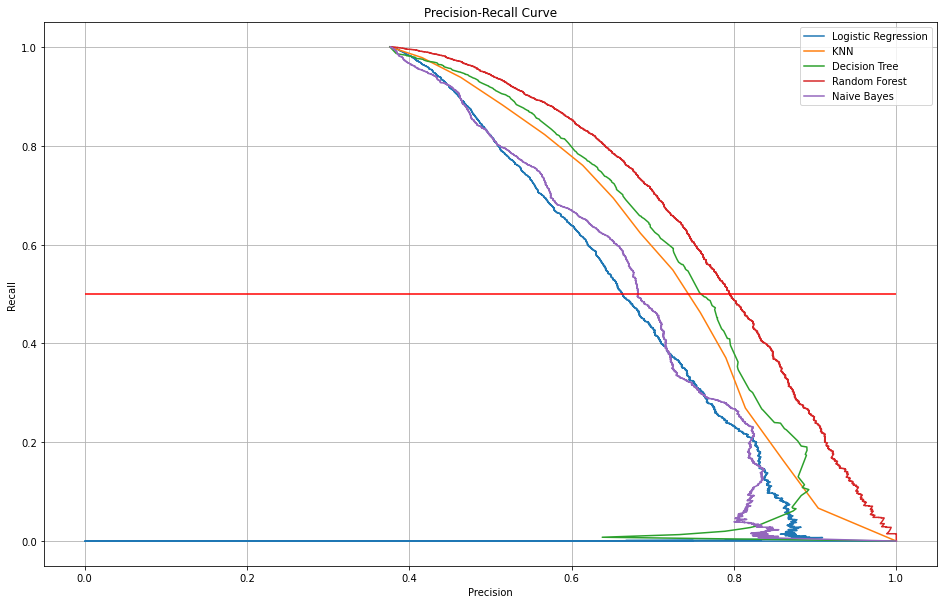

In [61]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=Y_test, probas_pred=lr_cv.predict_proba(X_test)[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true=Y_test, probas_pred=knn_cv.predict_proba(X_test)[:,1])
#precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_true=y_test, probas_pred=svm.predict_proba(X_test)[:,1])
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_true=Y_test, probas_pred=dt_cv.predict_proba(X_test)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=Y_test, probas_pred=rf_cv.predict_proba(X_test)[:,1])
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=Y_test, probas_pred=nb_cv.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(precision_lr, recall_lr, label='Logistic Regression')
ax.plot(precision_knn, recall_knn, label='KNN')
ax.plot(precision_dt, recall_dt, label='Decision Tree')
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_nb, recall_nb, label='Naive Bayes')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

We see that Random Forest produces the best model, with an accuracy of about 78%. This is about 15.5% better than the Dummy Model which just predicts that the user was not retained for every user. It is a significant improvement. In addition to having the highest accuracy of any model, we also see that it has the best AUC score of any model, or the best tradeoff between True positive rate and False positive rate. Note that, 'positive rate' is defined as the rate at which we correctly identify 'retained'. That is, we consider the positive class to be the retained customers, and the negative class to be the customers who were not retained. It is to be noted that we have no AUC score for our SVM model because the SVC class in scikit-learn does not have a predict_proba method.

Since Random Forest has the best AUC score and best accuracy, it is our best model.

We can  achieve better or worse results for accuracy, precision, and recall by varying the probability at which we classify retention. The probability threshold is set at 0.5 by default. But if we cared more about recall, for example, we would lower the threshold for classification such that we classified as retained more of the customers who were actually retained. This would come at the price of precision. Correspondingly, if we cared more about precision, we would raise the probability threshold.


To recap we wanted to :

# Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

We built several classification models to predict whether customers will be retained or not using the most common classification algorithms. We chose Random Forest model for prediction because it produced the best accuracy and AUC scores to all of the other classification models we used.

The biggest concern with Random Foreset model would be that we might value false negative more highly than false positives or vice-versa. That could be addressed by adjusting the probability threshold for classification. Random Forest remains the best model due to it having the best precision-recall curve of any model.

In terms of model validity, our model is only as accurate as the input data. Also, the model is only as good as the degree to which we know how to use it. That goes back to the point about precion-recall. First we have to know which we care about more before we can use our model optimally.

Finally, to recall,  we achieved an accuracy of about 78%, and an AUC score of about 84.7% for Random Forest.

# 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

To answer, these questions, we need model interpretability. The Random Forest model provides better interpretability than other models, particularly neural networks.

The feature importances for our model can't be extracted from a pipeline object. As a result, we need to run the model again, using the optimal parameters that have been found and check which features are the most important so that the new insights can be gained from the model to improve its longterm rider retention.

In [62]:
rf_cv.best_params_


{'classifier__criterion': 'entropy',
 'classifier__max_depth': 20,
 'classifier__max_features': 3,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 7,
 'classifier__n_estimators': 50,
 'preprocessor__num__imputer__strategy': 'mean'}

In [63]:
rf_model = rf_cv.best_estimator_


In [64]:
rf_model.named_steps['classifier'].feature_importances_


array([0.07287396, 0.0946823 , 0.05736528, 0.06949593, 0.08493398,
       0.04416002, 0.13768368, 0.1359289 , 0.12449299, 0.02722262,
       0.06768078, 0.01933287, 0.03240125, 0.00050753, 0.03123791])

In [65]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  int64  
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  int64  
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  was_retained            50000 non-null  int64  
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 4.6+ MB


In [66]:
user_df.describe()


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
count,50000.000000,50000.00000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,8.75422,0.617338,0.222336,61.718985,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,9.00000,4.300000,1.000000,45.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,17.00000,4.900000,1.000000,128.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [67]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
user1_df = pd.DataFrame(data)

user1_df['was_retained'] = (user1_df.last_trip_date >= '2014-06-01')*1
user1_df.last_trip_date = pd.to_datetime(user1_df.last_trip_date)
user1_df.signup_date = pd.to_datetime(user1_df.signup_date)

Test2 = []
for j in range(0,len(user1_df['signup_date'])):
    Test2.append(int((user1_df['signup_date'][j]).strftime("%Y%m%d")) - 20140100)

user1_df['signup_date'] = Test2
user1_df['last_trip_date'] = (user1_df['last_trip_date'] - min(user1_df['last_trip_date'])).dt.days + 1

#user1_df['signup_date'] = user1_df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
#user1_df['last_trip_date'] = (user1_df['last_trip_date'] - min(user1_df['last_trip_date'])).dt.days + 1 

user1_df.phone.fillna('Other', inplace=True)
user1_df['city'] = user1_df['city'].astype('category')
user1_df['phone'] = user1_df['phone'].astype('category')
user1_df = pd.get_dummies(user1_df)

In [68]:
# Imputation
user1_df.avg_rating_by_driver.fillna(user1_df.avg_rating_by_driver.mean(),inplace=True)
user1_df.avg_rating_of_driver.fillna(user1_df.avg_rating_of_driver.mean(),inplace=True)

In [70]:
# Split Data into Training and Test Sets

X1 = user1_df.drop(['was_retained', 'last_trip_date'], axis=1)
Y1 = user1_df['was_retained']

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.3, random_state=0, stratify=Y)

In [71]:
# Instantiate the model/estimator

classifier_rf = RandomForestClassifier(random_state=0, criterion='gini', max_depth=20, 
                                       max_features=4, min_samples_leaf=7, min_samples_split=5, n_estimators=100)


It takes 2.560 seconds for Random Forest fitting
Accuracy with Random Foreston the testing set is: 0.778
ROC AUC score is: 0.848
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8032      1327   9359
Retained              1998      3643   5641
Total                10030      4970  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.73      0.65      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



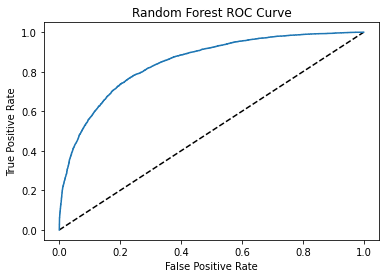

In [76]:
# Fit on Training
t0 = time.time()
classifier_rf.fit(X1_train, Y1_train)
ttt = time.time() - t0 # ttt stands for "time to train"
print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

# Step 7: Predict on Test
Y1_pred = classifier_rf.predict(X1_test)

# Step 8: Scoring

# Accuracy
print("Accuracy with " + 'Random Forest' + "on the testing set is: %.3f" % classifier_rf.score(X1_test, Y1_test))
    
y1_pred_prob = classifier_rf.predict_proba(X1_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(Y1_test, y1_pred_prob))
print(Conf_Matrix(confusion_matrix(Y1_test, Y1_pred)))
print(classification_report(Y1_test, Y1_pred))

# ROC Curve
fpr, tpr, thresholds  = roc_curve(Y1_test, y1_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Random Forest')
plt.show()

In [77]:
pd.DataFrame(classifier_rf.feature_importances_, 
             index = X1_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
avg_rating_by_driver,0.151980
weekday_pct,0.130413
surge_pct,0.112422
city_King's Landing,0.098508
avg_dist,0.089670
avg_surge,0.083304
trips_in_first_30_days,0.062173
signup_date,0.059697
ultimate_black_user,0.052550
avg_rating_of_driver,0.041451


So, we see that the top 3 features in terms of importance are :

- avg_rating_of_driver : the rider’s average rating of their drivers over all of their trips
- weekday_pct : the percent of the user’s trips occurring during a weekday
- surge_pct : the percent of trips taken with surge multiplier > 1


In [82]:
print(user1_df['avg_rating_by_driver'].corr(user1_df['was_retained']))
print(user1_df['surge_pct'].corr(user1_df['was_retained']))
print(user1_df['weekday_pct'].corr(user1_df['was_retained']))

-0.026748042806070883
0.011796748066780095
0.009692972843291863


We see these top three important features are correlated with our target variable in a very small way! We can make interesting points from these results : 

- Average rating by driver is negatively correlated with retention. It means higher rated users (over all of their trips) are less likely to be retained. This suggests we would want uses to be poorly rated so that they have higher retention. Perhaps, highly rated users have higher expectations so they keep looking for alternatives. Even 
in that case, this is a puzzling inference.

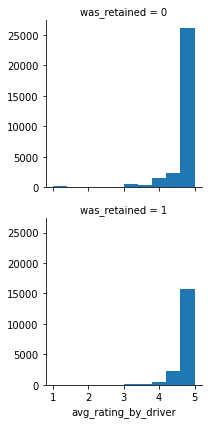

In [85]:
g1 = sns.FacetGrid(user1_df, row='was_retained')
g1 = g1.map(plt.hist, "avg_rating_by_driver")

The second most important feature was the percent of trips taken with surge multiplier > 1. This is very slightly positively correlated with retention.

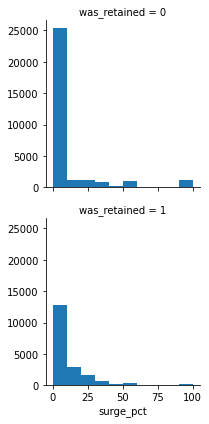

In [88]:
g2 = sns.FacetGrid(user1_df, row='was_retained')
g2 = g2.map(plt.hist, "surge_pct")

There is no clear connection observed.  We can say that Ultimate should investigate more research into the effects of surges on user retention. Perhaps, the surges prices are too high to attract the users.

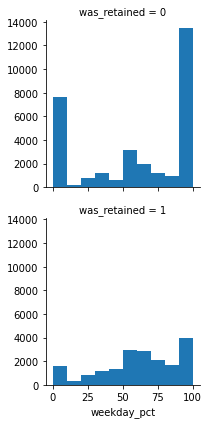

In [89]:
g3 = sns.FacetGrid(user1_df, row='was_retained')
g3 = g3.map(plt.hist, "weekday_pct")

For our last important feature, weekday_pct, the percent of the user's trips  occuring on a weekday, we see that the non-retained user distribution (was_retained = 0) shows far more users who either only use it on the weekend (first bar), or only use it during the week (last bar - 100 % in the week). 

A recommendation here would be for Ultimate to target those users who experience no difference in their need for transportation between the week and the weekend. Those users need to be attracted to be retained.

Final point - It is largely dependent on a solution available online but modification made at many places. I thought following this comprehensive solution would be a good learning exercise! Thank you.